# Are you a fan of Mayor Han?

<img src="https://i.imgur.com/GgPPfk4.png" width="900" />

(image source: [link](https://www.storm.mg/article/525105?srcid=gAAAAABcsea_WZX1btdtDfPbAuBP8p_-9GcnyFvKDxXCZIjJg9dNW26Gskj7oZGDlmsQQjZQq_6v0Pqx57FbQhbMy7_D2Mveyf8pecA6NS_0Kxhj9N1P1CI%253D))

## 1. Define Question
Recently, Mayor of Kaohsiung Han Kuo-yu (韓國瑜) is in fasion, and even his name became a buzzword.
In this section, I'll **determine whether a person is a fan of Mayor Han, otherwise, Chi-Mai**.

## 2. Design attributes (features)
This dataset contains 20000 rows. The attributes are:
- **gender**: male(1) / female(0)
- **age**: int
- **party**: KMT(1) / Democratic Progressive Party(2) / None(3)
- **hasMCTfamily**: 0 / 1
    - if any of your family works as a military personnel, a civil servant or a teacher
- **loveFerrisWheel**: 0 / 1
- **loveMoney**: 0 / 1

and the label indicates whether this person loves mayor Han or not:
- **fanOfHan**: 0 / 1

## 3. Define rules:
This is a simple decision tree that defined the rules. The rules are so meaningful that it directly reflects the real-world situation. Let me tell you how these are made.
1. If one's party is KMT, he/she has a great chance to be a fan of Han. But not all of them. One thing can be sure of is that people who loves ferris wheel loves Han. Without questions. Another evidence shows that middle-aged women is obsessed with Han.
2. If one is not of party 'KMT', we still have another clue. If one has any of his/her family that works as a military personnel, a civil servant or a teacher, he's probably pissed by the 'Democratic Progressive Party', because of the "pension reform (年金改革)" policy. Thus, he/she might be forced to support Han in order not to let Chi-Mai Chen, who stands for Democratic Progressive Party, win the election. But this is not always true. If any of them don't love money, well , they might still stick to Chi-Mai.
<img src="imgs/rules_simple.png" width="700" />


## 4. Generate mock dataset 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import random
import math

### gender
- according to [wikipedia](https://zh.wikipedia.org/wiki/%E8%87%BA%E7%81%A3%E4%BA%BA%E5%8F%A3#%E4%BA%BA%E5%8F%A3), the average ratio of male and femail is about 0.99
- 1: male
- 0: female

,gender
0,1
1,1
2,1
3,1
4,1


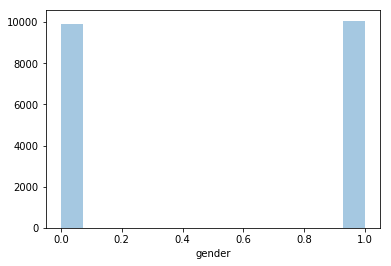

In [2]:
def decideGenger(n):
    return 1 if n*random.uniform(0, 1) < 0.5 else 0

pdata = pd.DataFrame(1, index=range(0,20000), columns=['gender'])
pdata['gender'] = pdata['gender'].apply(decideGenger)
sns.distplot(pdata['gender'], kde=False)
pdata.head()

### age
- again, according to [wikipedia](https://zh.wikipedia.org/wiki/%E8%87%BA%E7%81%A3%E4%BA%BA%E5%8F%A3#%E4%BA%BA%E5%8F%A3), we can consider this a normal distribution
- I simply set mean = 50, and std,dev = 15

,gender,age
0,1,51
1,1,65
2,1,65
3,1,42
4,1,39


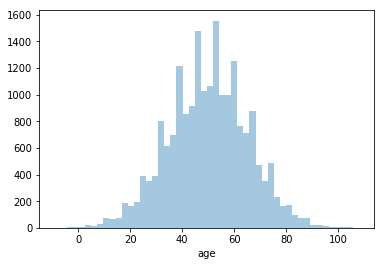

In [3]:
# pdata['age'] = 0
def decideAge(n):
    if n < 15:
        return 20
    elif n > 90:
        return 85

mu, sigma = 50, 15 # mean and standard deviation
pdata['age'] = np.random.normal(mu, sigma, 20000)
pdata['age'] = pdata['age'].apply(round)
sns.distplot(pdata['age'], kde=False)
pdata.head()

### party
- from the research [1992/06~2018/12](https://esc.nccu.edu.tw/app/news.php?Sn=165#), we can tell the party preference distribution.
- random_percent = random(0, 1.0)
- if random_percent <= 0.246, then 'Democratic Progressive Party'
- else if 0.246 < random_percent <= 0.561, then 'KMT'
- else 'none'
- 'KMT' = 1, 'Democratic Progressive Party' = 2, 'None' = 3
![](https://i.imgur.com/2XfwH3V.png)
(image source: [link](https://esc.nccu.edu.tw/app/news.php?Sn=165#))

,gender,age,party
0,1,51,3
1,1,65,3
2,1,65,3
3,1,42,3
4,1,39,1


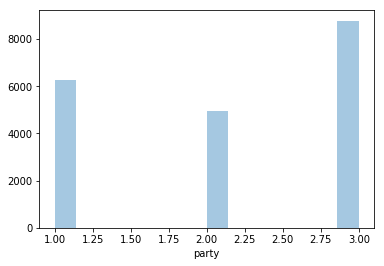

In [4]:
def decideParty(n):
    n = n*random.uniform(0, 1)
    if n <= 0.246:
        return 2
    elif n > 0.246 and n <= 0.561:
        return 1
    else:
        return 3

pdata['party'] = 1
pdata['party'] = pdata['party'].apply(decideParty)
sns.distplot(pdata['party'], kde=False)
pdata.head()

### hasMCTfamily
- if one's family works as a **military personnel**, a **civil servant** or a **teacher** (軍公教人員), there's a great chance that he/she won't like Democratic Progressive Party, because of the "pension reform (年金改革)" policy, thus, he/she might be forced to support Han in order not to let Chi-Mai Chen, who stands for Democratic Progressive Party, win the election.
- from [this report](http://www.fund.gov.tw/public/data/6851558871.pdf), I found that around 3% of population works as a military personnel, a civil servant or a teacher. and let's assume all their family feel sad for them and thus decide to select Mayor Han, with each family 6 people. That's total 18% approximately.
- randomly choose 18% from dataset

,gender,age,party,hasMCTfamily
0,1,51,3,0
1,1,65,3,0
2,1,65,3,0
3,1,42,3,0
4,1,39,1,0


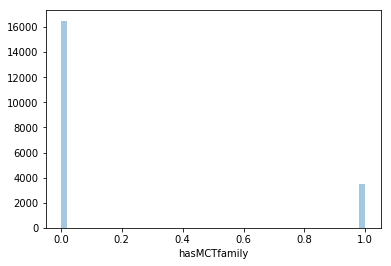

In [5]:
def decideMCTfamily(_):
    n = random.uniform(0, 1)
    return 1 if n <= 0.18 else 0

pdata['hasMCTfamily'] = 1
pdata['hasMCTfamily'] = pdata['hasMCTfamily'].apply(decideMCTfamily)
sns.distplot(pdata['hasMCTfamily'], kde=False)
pdata.head()

### loveMoney
- "Sell Goods, welcome people, prosperous Kaohsiung." --- by Mayor Han
- most people love money.

,gender,age,party,hasMCTfamily,loveMoney
0,1,51,3,0,1
1,1,65,3,0,0
2,1,65,3,0,0
3,1,42,3,0,1
4,1,39,1,0,1


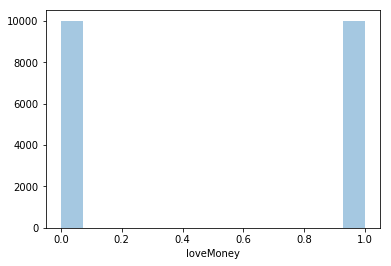

In [6]:
pdata['loveMoney'] = 1
for index, row in pdata.iterrows():
#     pdata.at[index,'loveChina'] = 1 if row['party'] == 'KMT' and random.uniform(0, 1) > 0.3 else 0
    pdata.at[index,'loveMoney'] = random.randint(0, 1) # 1 if random.uniform(0, 1) > 0.5 else 0
sns.distplot(pdata['loveMoney'], kde=False)
pdata.head()

### loveFerrisWheel
- haters' gonna hate.
- randomly selected (50%)

,gender,age,party,hasMCTfamily,loveMoney,loveFerrisWheel
0,1,51,3,0,1,1
1,1,65,3,0,0,1
2,1,65,3,0,0,0
3,1,42,3,0,1,1
4,1,39,1,0,1,0


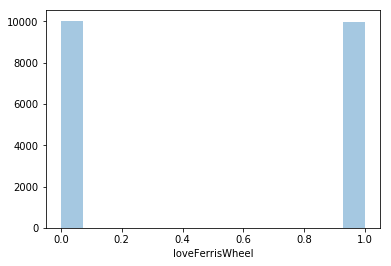

In [7]:
def decideLoveFerrisWheel(_):
    return random.randint(0, 1) # 1 if random.uniform(0, 1) < 0.5 else 0

pdata['loveFerrisWheel'] = 1
pdata['loveFerrisWheel'] = pdata['loveFerrisWheel'].apply(decideLoveFerrisWheel)
sns.distplot(pdata['loveFerrisWheel'], kde=False)
pdata.head()

### fanOfHan
Now, label the dataset based on the designed rules.

In [8]:
pdata['fanOfHan'] = 0
for index, row in pdata.iterrows():
    if (row['party'] == 1):
        if (row['loveFerrisWheel'] == 1):
            pdata.at[index,'fanOfHan'] = 1
        else:
            if (row['gender'] == 0) and (row['age'] >= 55):
                pdata.at[index,'fanOfHan'] = 1
    else:
        if (row['hasMCTfamily'] == 1):
            if (row['loveMoney'] == 1):
                pdata.at[index,'fanOfHan'] = 1

# save the dataset as csv
pdata.to_csv('mock_data.csv')
pdata.head()

,gender,age,party,hasMCTfamily,loveMoney,loveFerrisWheel,fanOfHan
0,1,51,3,0,1,1,0
1,1,65,3,0,0,1,0
2,1,65,3,0,0,0,0
3,1,42,3,0,1,1,0
4,1,39,1,0,1,0,0


## 5. Construct Decision Tree:

### Seperate to training set and testing set

In [9]:
pdata_train = pdata[:15000]
pdata_test = pdata[15000:]

### Seperate attributes and answer

In [10]:
y = pdata_train['fanOfHan'].values
pdata_train = pdata_train.drop('fanOfHan', axis=1)

### Draw Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus

dtree=DecisionTreeClassifier(max_depth=6)
dtree.fit(pdata_train, y)

dot_data = StringIO()
export_graphviz(dtree, 
                out_file=dot_data,  
                filled=True, 
                feature_names=list(pdata_train),
                class_names=['Chi Mai','Mayor Han'],
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_pdf("tree.pdf")
graph.write_png("imgs/tree.png")

True

<img src="imgs/tree.png" width="700" />

### calculate accuracy

In [12]:
y_test = pdata_test['fanOfHan'].values
X_test = pdata_test.drop('fanOfHan', axis=1)

y_predict = dtree.predict(X_test)

y_predict

array([0, 0, 0, ..., 1, 0, 0])

In [13]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict)

1.0

# Report

## 6. Compare the rules

### (a). Original rules v.s rules generated by decision tree

#### Original rules:
<img src="imgs/rules_simple.png" width="500" />

#### Generated rules:
<img src="imgs/tree.png" width="500" />


### (b). Observation
- WOW, the generated rules and the original rules perfectly matched! Even the order! The world doesn't lie.
- Let's look at the "party" attribute. The decision tree said "party < 1.5", and only KMT has value 1, which is less than 1.5. As for why 1.5 instead of 1 ? this is due to the **"information gain"** calculation. The decision Tree tends to choose the gini value that get higher information gain. The information gain of my original rule is **0.074**, and the information gain calculated by the decision tree is **0.113** (The process is shown below). Therefore, the decision tree choosed value 1.5 as a separation, and "party = 1" matched the rule.
- Let's look at the left part. The second decision rule is 'age <= 54.5', the result went to 'Chi-Mai' class. Whihc means, if age >= 55, it futher checked if one's gender is female. This is also correct. The reason why it is 54.5 instead of 55 is also due to information gain calculation.
- As for the rest of the decision rules are all 1 or 0, which are presented as greater or smaller than 0.5. And again, The reason why 0.5 over 1 is due to information gain calculation. These are also correct!

#### gini and information gain calculation:

In [15]:
# prove why 1.5 instead of 1
left = pdata[pdata['party'] <= 1].count()[0]
right = pdata.shape[0] - left
gini_party = 1 - (pow(left/(left+right), 2) + pow(right/(left+right), 2))

left = pdata[(pdata['party'] <= 1) & (pdata['loveFerrisWheel'] < 1)].count()[0]
right = pdata[pdata['party'] <= 1].count()[0] - left
total_loveFerrisWheel = left+right
gini_loveFerrisWheel = 1 - (pow(left/(left+right), 2) + pow(right/(left+right), 2))

left = pdata[(pdata['party'] > 1) & (pdata['hasMCTfamily'] < 1)].count()[0]
right = pdata[pdata['party'] > 1].count()[0] - left
total_hasMCTfamily = left+right
gini_hasMCTfamily = 1 - (pow(left/(left+right), 2) + pow(right/(left+right), 2))

informationGain_myrule = gini_party - (gini_loveFerrisWheel*total_loveFerrisWheel + gini_hasMCTfamily*total_hasMCTfamily) / (total_loveFerrisWheel + total_hasMCTfamily)
print('information gain of my rule is', informationGain_myrule)

informationGain_dt = 0.371 - (0.48*4700 + 0.156*10300) / 15000
print('information gain of decision tree is', informationGain_dt)

information gain of my rule is 0.07472784235550395
information gain of decision tree is 0.11347999999999997


## 7. Futher Discussion
### (a). If we try more complicated rules, will the tree still look similar ?
<img src="imgs/complicated_rules.png" width="500" />

In [16]:
test_data = pdata.copy()
test_data = test_data.drop('fanOfHan', axis=1)
test_data['fanOfHan'] = 0
# complicated rules
for index, row in test_data.iterrows():
    if (row['party'] == 1):
        test_data.at[index,'fanOfHan'] = 1
    else:
        if (row['loveMoney'] == 1):
            if (row['loveFerrisWheel'] == 1):
                test_data.at[index,'fanOfHan'] = 1
        else:
            if (row['hasMCTfamily'] == 1):
                if (row['party'] == 2):
                    test_data.at[index,'fanOfHan'] = 1
            else:
                if (row['age'] >= 55):
                    if (row['gender'] == 0):
                        test_data.at[index,'fanOfHan'] = 1
                        
test_data.head()

,gender,age,party,hasMCTfamily,loveMoney,loveFerrisWheel,fanOfHan
0,1,51,3,0,1,1,1
1,1,65,3,0,0,1,0
2,1,65,3,0,0,0,0
3,1,42,3,0,1,1,1
4,1,39,1,0,1,0,1


In [17]:
# split to train, test, y
test_data_train = test_data[:15000]
test_data_test = test_data[15000:]

test_y = test_data_train['fanOfHan'].values
test_data_train = test_data_train.drop('fanOfHan', axis=1)

# draw the tree
dtree=DecisionTreeClassifier(max_depth=10)
dtree.fit(test_data_train, test_y)

dot_data = StringIO()
export_graphviz(dtree, 
                out_file=dot_data,  
                filled=True, 
                feature_names=list(test_data_train),
                class_names=['Chi Mai','Mayor Han'],
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("imgs/test_complicated.png")

True

<img src="imgs/test_complicated.png" width="1000" />

### accuracy

In [18]:
y_test = test_data_test['fanOfHan'].values
X_test = test_data_test.drop('fanOfHan', axis=1)

y_predict = dtree.predict(X_test)

accuracy_score(y_test, y_predict)

1.0

### Observation
- The tree looks very differnet, though the accuracy can still be 100%.
- The left part stays the same as the rules.
- If we break the tree down to small pieces, we can still find some of the original rules. For instance, check for 'hasMCTfamily' and then check if 'party = Democratic Progressive Party'.
- Another one is the check for age and the check for gender, this is also the same idea as the designed rules.

### (b). If we add some noise to the dataset under the simple rules, what will the tree be like ?

In [19]:
test_data = pdata.copy()

# randomly select rows to add noise
idx = list(random.randint(0, 20000-1) for x in range(1, 20))
print(idx)
for i in idx:
    test_data.loc[i] = [
        random.randint(0, 1),
        random.randint(20, 90),
        random.randint(1, 3),
        random.uniform(0, 1),
        random.randint(0, 1),
        random.randint(0, 1),
        random.randint(0, 1)
    ]

test_data_train = test_data[:15000]
test_data_test = test_data[15000:]
test_y = test_data_train['fanOfHan'].values
test_data_train = test_data_train.drop('fanOfHan', axis=1)
test_data_train.head()

[10316, 8743, 6599, 10878, 19525, 69, 7291, 8158, 14759, 11995, 12946, 604, 2040, 8373, 12690, 14218, 16053, 926, 16504]


,gender,age,party,hasMCTfamily,loveMoney,loveFerrisWheel
0,1,51,3,0.0,1,1
1,1,65,3,0.0,0,1
2,1,65,3,0.0,0,0
3,1,42,3,0.0,1,1
4,1,39,1,0.0,1,0


In [20]:
dtree.fit(test_data_train, test_y)

dot_data = StringIO()
export_graphviz(dtree, 
                out_file=dot_data,  
                filled=True, 
                feature_names=list(test_data_train),
                class_names=['Chi Mai','Mayor Han'],
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("imgs/test_noise.png")

True

<img src="imgs/test_noise.png" width="900" />

### accuracy

In [21]:
y_test = test_data_test['fanOfHan'].values
X_test = test_data_test.drop('fanOfHan', axis=1)

y_predict = dtree.predict(X_test)

accuracy_score(y_test, y_predict)

0.9992

### Observation

- The tree structure is affected and thus became much more complicated.
- It shows that the structure of Decision Tree is prone to noise, even when only 0.1% of the data is randomly made.
- As we can see, at the bottom of the tree, some of the rules is added only to distinguish 3 or less data, which is a noise. This is because decision tree only tells true or false. It'll tell you false if there is any special case.
- However, it seems like that the accuracy isn't affected that much though. The tree is still well functioning while it looks complicated.

### (c). If we increase the weight fraction (default is 0) of Decision Tree, how will the result be?

In [22]:
test_data = pdata.copy()
test_data_train = test_data[:15000]
test_data_test = test_data[15000:]
test_y = test_data_train['fanOfHan'].values
test_data_train = test_data_train.drop('fanOfHan', axis=1)

In [23]:
dtree=DecisionTreeClassifier(max_depth=6, min_weight_fraction_leaf=0.1) # increase the fraction
dtree.fit(pdata_train, y)

dot_data = StringIO()
export_graphviz(dtree, 
                out_file=dot_data,  
                filled=True, 
                feature_names=list(pdata_train),
                class_names=['Chi Mai','Mayor Han'],
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("imgs/test_fraction.png")

True

<img src="imgs/test_fraction.png" width="600" />

### accuracy

In [24]:
y_test = test_data_test['fanOfHan'].values
X_test = test_data_test.drop('fanOfHan', axis=1)

y_predict = dtree.predict(X_test)

accuracy_score(y_test, y_predict)

0.912

### Observation
- At the bottom, there are still lots of values that couldn't be classified.
- The accuracy turns out poorer.
- This is because the weight of the left data is less than 1% of 20000, or 2000 data, which is not enough to be at a leaf node. Thus the result is unsatisfied.